In [1]:
import os.path
import cv2
import numpy as np
from random import randrange
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline

In [51]:
#Function to create point cloud file
def create_output(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3),colors])

    ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
    for i in range(0,reduce_factor):
        #Check if image is color or grayscale
        if len(image.shape) > 2:
            row,col = image.shape[:2]
        else:
            row,col = image.shape

        image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
    return image

In [81]:
img1 = cv2.imread(r'C:\Users\mar10675\Downloads\Photos\test1.jpg')  #queryimage # left image
img2 = cv2.imread(r'C:\Users\mar10675\Downloads\Photos\test2.jpg') #trainimage # right image

In [82]:
#Camera parameters (pixels)
fx = fy = 2839.64
cx = 2000
cy = 1500

k1 = -0.042563
k2 = 0.0259073
p1 = 0.00119999
p2 = 0.00169852
k3 = -0.00608853

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])
dist = np.array([k1, k2, p1, p2, k3])

#Get height and width. Note: It assumes that both pictures are the same size.
h,w = img1.shape[:2]

#Get optimal camera matrix for better undistortion 
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K,dist,(w,h),1,(w,h))

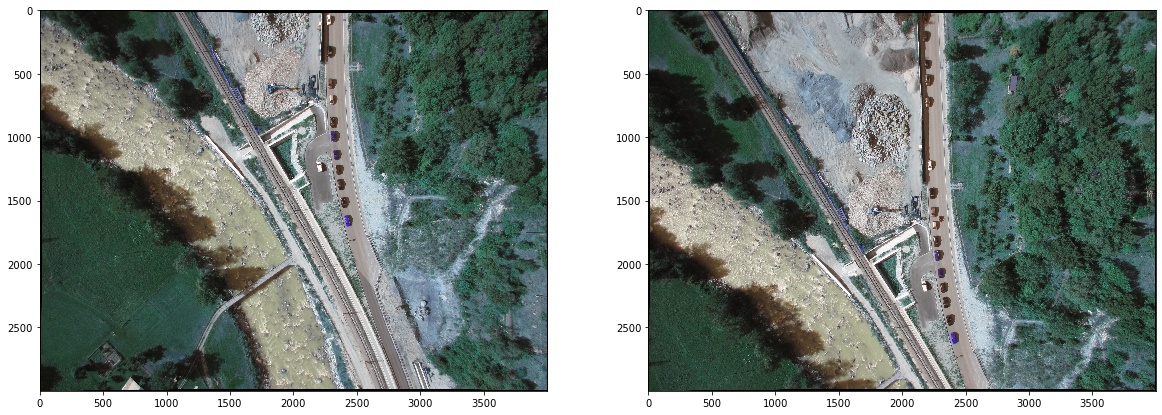

In [83]:
#Undistort images
img1_undistorted = cv2.undistort(img1, K, dist, None, new_camera_matrix)
img2_undistorted = cv2.undistort(img2, K, dist, None, new_camera_matrix)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img1_undistorted, cmap='gray')
ax2.imshow(img2_undistorted, cmap='gray')

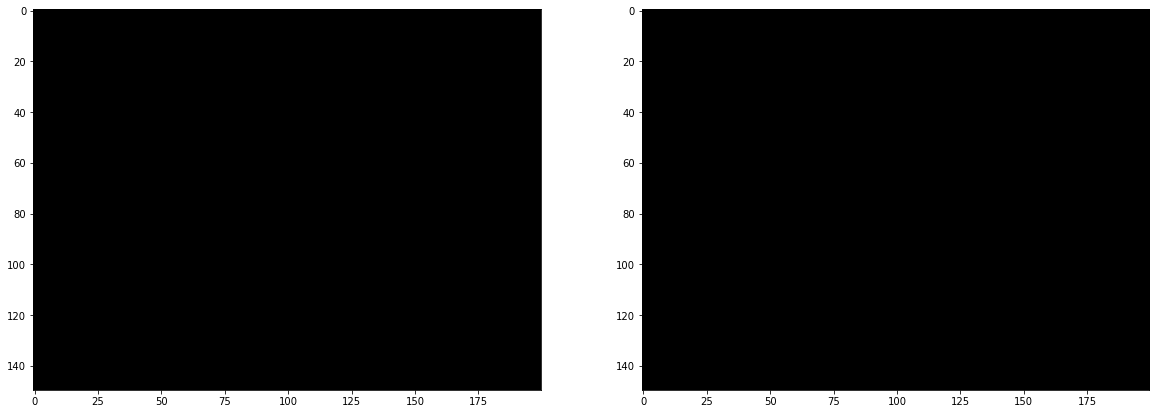

In [84]:
#Downsample each image 3 times (because they're too big)
img_1_downsampled = downsample_image(img_1_undistorted,3)
img_2_downsampled = downsample_image(img_2_undistorted,3)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(img_1_downsampled, cmap='gray')
ax2.imshow(img_2_downsampled, cmap='gray')


Computing the disparity  map...


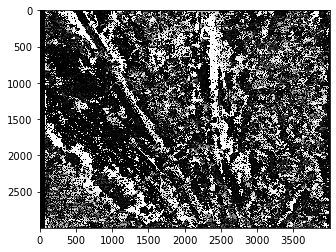

In [88]:
#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16

#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
    numDisparities = num_disp,
    blockSize = 5,
    uniquenessRatio = 5,
    speckleWindowSize = 5,
    speckleRange = 5,
    disp12MaxDiff = 2,
    P1 = 8*3*win_size**2,#8*3*win_size**2,
    P2 =32*3*win_size**2) #32*3*win_size**2)

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img1_undistorted, img2_undistorted)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity_map,'gray')
plt.show()


In [86]:
#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me. 
Q = np.float32([[1,0,0,-w/2.0],
				[0,-1,0,h/2.0],
				[0,0,0,-fx],
				[0,0,1,0]])

In [87]:
#Reproject points into 3D
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
#Get color points
colors = cv2.cvtColor(img1_undistorted, cv2.COLOR_BGR2RGB)

#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()

#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]

#Define name for output file
output_file = 'reconstructed.ply'

#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)


 Creating the output file... 



In [136]:
surf = cv2.xfeatures2d_SURF.create(hessianThreshold=400)

# find the keypoints and descriptors with SIFT
kp1, des1 = surf.detectAndCompute(img1,None)
kp2, des2 = surf.detectAndCompute(img2,None)

In [137]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

#flann = cv2.FlannBasedMatcher(index_params,search_params)
#matches = flann.knnMatch(des1,des2,k=2)

bf = cv2.BFMatcher.create(cv2.NORM_L2 , crossCheck=True)
matches = bf.match(des1, des2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, m in enumerate(matches):
    if i < len(matches) - 1 and m.distance < 0.7 * matches[i+1].distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
print(f'using {len(pts1)} of {len(matches)} matches')

using 165 of 782 matches


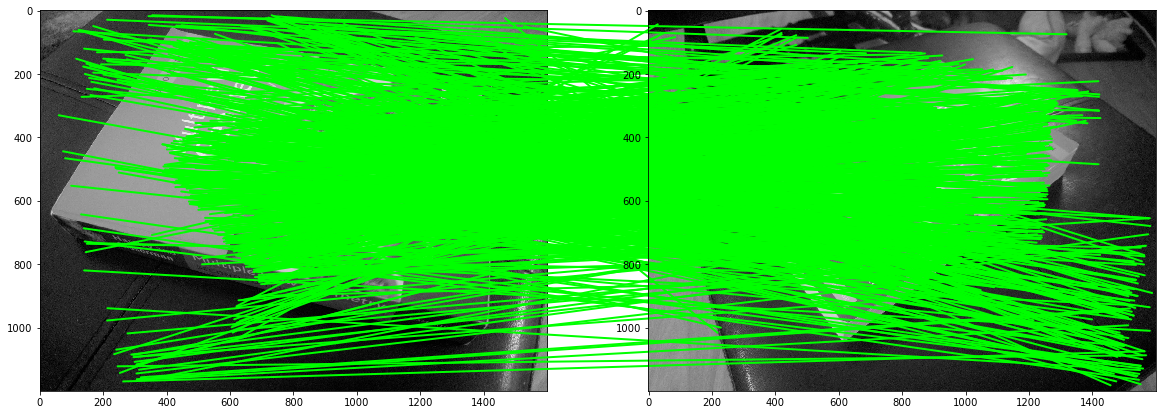

In [138]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for match in matches:
    k1 = kp1[match.queryIdx]
    k2 = kp2[match.trainIdx]

    con = ConnectionPatch(xyA=k1.pt, xyB=k2.pt, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color=(0,1,0), linewidth=2.0)

    ax2.add_artist(con)

ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

plt.show()

In [139]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [140]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

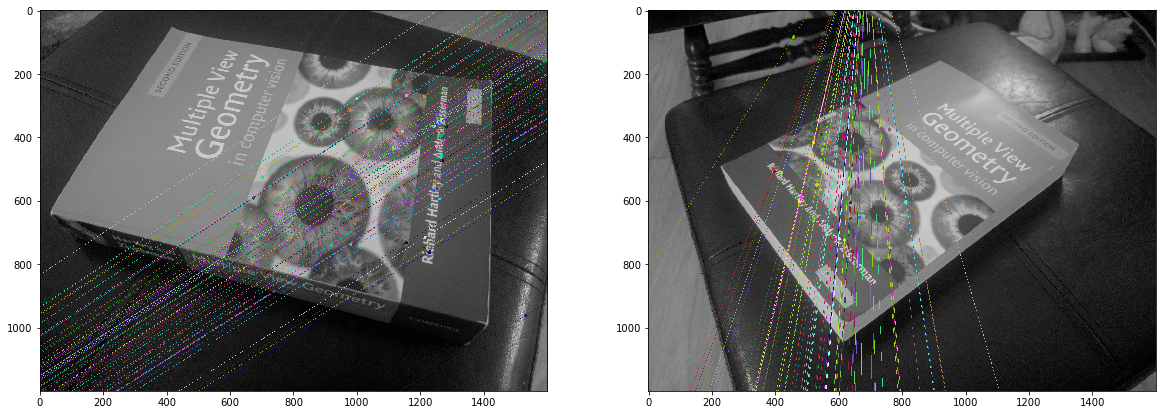

In [141]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

fig = plt.figure(figsize=(20,20))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()